

```
***# Importing Libraries***
```



In [11]:
import re
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [12]:
print('Importing Done')

Importing Done


*Importing* *Dataset* ***from google drive ***

In [13]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis - DL/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*** Starting EDA***

In [14]:
## Data exploration ##
desired_width = 320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns', 10)
train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [15]:
## Dataset Length ##
len(train)

27481

In [16]:
## finding other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [19]:
## Checking How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


In [20]:
## describe the dataset
train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [21]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

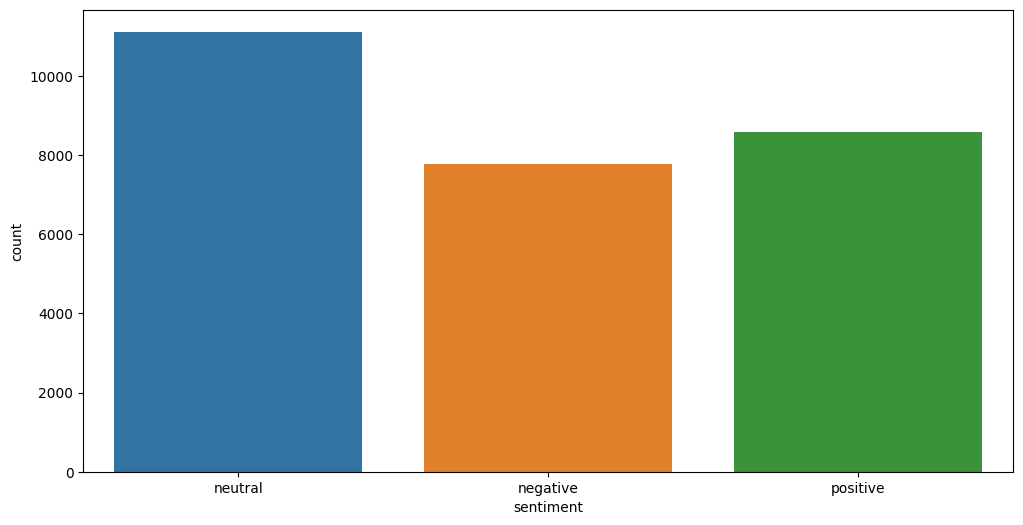

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [24]:
from plotly import graph_objs as go
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

*** Ending EDA ***

*** Starting Data Cleaning & Prepairing Data for Processing ***

In [26]:
## Data Cleaning ##
train = train[['selected_text', 'sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [27]:
## Checking for null value ##
train["selected_text"].isnull().sum()

1

In [28]:
## Filling the null value ##
train["selected_text"].fillna("No content", inplace=True)

In [29]:
## clean data method remove unnecessary Items ##
def clean_data(data):
    # Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
    # Remove new line characters
    data = re.sub('\s+', ' ', data)
    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    return data

In [30]:
## Splitting of Data ##
temp = []
# Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [31]:
## sent_to_words converts to sentence to word ##
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [32]:
data_words = list(sent_to_words(temp))
data_words[:10]

[['have', 'responded', 'if', 'were', 'going'],
 ['sooo', 'sad'],
 ['bullying', 'me'],
 ['leave', 'me', 'alone'],
 ['sons', 'of'],
 ['some',
  'shameless',
  'plugging',
  'for',
  'the',
  'best',
  'rangers',
  'forum',
  'on',
  'earth'],
 ['fun'],
 ['soooo', 'high'],
 ['both', 'of', 'you'],
 ['wow', 'just', 'became', 'cooler']]

In [33]:
## checking the length of data_words ##
len(data_words)

27481

In [34]:
## detokenize method convert words to sentence ##
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [35]:
## printing converted sentences ##
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
data[:5]

['have responded if were going',
 'sooo sad',
 'bullying me',
 'leave me alone',
 'sons of']

In [36]:
## Converting to numpy array ##
data = np.array(data)

In [37]:
## Label encoding ##
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [39]:
## checking the length of labels ##
len(labels)

27481

In [40]:
## Data sequencing and splitting ##
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
tweets

array([[   0,    0,    0, ...,   68,  146,   41],
       [   0,    0,    0, ...,    0,  397,   65],
       [   0,    0,    0, ...,    0,    0,   11],
       ...,
       [   0,    0,    0, ...,  372,   10,    3],
       [   0,    0,    0, ...,   24,  542,    4],
       [   0,    0,    0, ..., 2424,  199,  657]], dtype=int32)

In [41]:
## printing the labels
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [42]:
## Splitting the data ##
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train), len(X_test), len(y_train), len(y_test))

20610 6871 20610 6871


*** Ending Data Cleaning & Prepairation for the Processing ***

*** Applying Deep Learning Model (Start) ***

In [43]:
## no of epochs ##
no_epoch = 70

***## Model building ##***

***## Single LSTM layer model (Start)***

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15, dropout=0.5))
model1.add(layers.Dense(3, activation='softmax'))

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True,
                              save_weights_only=False, mode='auto', save_freq='epoch')
history = model1.fit(X_train, y_train, epochs=no_epoch, validation_data=(X_test, y_test), callbacks=[checkpoint1])
history

Epoch 1/70
645/645 [==============================] - ETA: 0s - loss: 0.8303 - accuracy: 0.6251
Epoch 1: val_accuracy improved from -inf to 0.70004, saving model to best_model1.hdf5
645/645 [==============================] - 60s 88ms/step - loss: 0.8303 - accuracy: 0.6251 - val_loss: 0.7149 - val_accuracy: 0.7000
Epoch 2/70
645/645 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.7542
Epoch 2: val_accuracy improved from 0.70004 to 0.77732, saving model to best_model1.hdf5
645/645 [==============================] - 57s 88ms/step - loss: 0.6264 - accuracy: 0.7542 - val_loss: 0.5607 - val_accuracy: 0.7773
Epoch 3/70
645/645 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.7906
Epoch 3: val_accuracy improved from 0.77732 to 0.78999, saving model to best_model1.hdf5
645/645 [==============================] - 56s 86ms/step - loss: 0.5255 - accuracy: 0.7906 - val_loss: 0.5198 - val_accuracy: 0.7900
Epoch 4/70
645/645 [=============================

***## Single LSTM layer model (End)***

***## Bidirectional LTSM model (Start)***

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
model2.add(layers.Dense(3, activation='softmax'))
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True,
                              save_weights_only=False, mode='auto', save_freq='epoch')
history = model2.fit(X_train, y_train, epochs=no_epoch, validation_data=(X_test, y_test), callbacks=[checkpoint2])
history

***## Bidirectional LTSM model (End)***

***## 1D Convolutional model (Start)***

In [ ]:
from keras import regularizers

model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),
                         bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),
                         bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3, activation='softmax'))
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True,
                              save_weights_only=False, mode='auto', save_freq='epoch')
history = model3.fit(X_train, y_train, epochs=no_epoch, validation_data=(X_test, y_test), callbacks=[checkpoint3])
history

***## 1D Convolutional model (End)***

*** Applying Deep Learning Model (End) ***

***## Best model validation ##***

In [ ]:
best_model = keras.models.load_model("best_model2.hdf5")
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ', test_acc)
predictions = best_model.predict(X_test)
predictions

***## Confusion matrix ##***

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
import seaborn as sns

conf_matrix = pd.DataFrame(matrix, index=['Neutral', 'Negative', 'Positive'],
                           columns=['Neutral', 'Negative', 'Positive'])
# Normalizing
conf_matrix = conf_matrix.to_numpy() / conf_matrix.to_numpy().sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
plt.show()

***## Performance on Some Testing Text***

In [ ]:
sentiment = ['Neutral', 'Negative', 'Positive']

sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
print(sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]])
print('\n')

sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
print(sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]])
print('\n')

sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
print(sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]])
print('\n')

sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
print(sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]])

*** 😃 END 😃 ***

---

: